In [1]:
# Let's import the stuff we need
import torch
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.algo.trajectory_balance import TrajectoryBalance
import numpy as np
torch.__version__

from rdkit import Chem
import numpy as np
from rdkit import RDLogger

# Get the logger
lg = RDLogger.logger()

# Disable all RDKit warnings
lg.setLevel(RDLogger.CRITICAL)

def graph_to_obj(self, g):

    def safe_mol(m):
        """Convert None or invalid input into an empty RDKit molecule."""
        return m if isinstance(m, Chem.Mol) else Chem.RWMol().GetMol()

    # ---------------------------------------------------------
    # 1) Base molecule: always start with an empty mol
    # ---------------------------------------------------------
    mol = Chem.RWMol().GetMol()      # <-- ALWAYS valid, never None
    first = True                     # track first fragment

    # Atom index offsets
    offsets = np.cumsum(
        [0] + [self.frags_numatm[g.nodes[i]["v"]] for i in g]
    )

    # ---------------------------------------------------------
    # 2) Add all fragments
    # ---------------------------------------------------------
    for i in g.nodes:
        idx = g.nodes[i]["v"]

        # force fragment into a valid molecule
        frag = safe_mol(self.frags_mol[idx])

        if first:
            mol = frag
            first = False
        else:
            mol = Chem.CombineMols(mol, frag)

    # If graph had *no nodes*, mol is still empty — that's OK!
    rw = Chem.RWMol(mol)  # <-- NOW GUARANTEED SAFE

    # ---------------------------------------------------------
    # 3) Add bonds
    # ---------------------------------------------------------
    bond_atoms = []
    for a, b in g.edges:
        afrag = g.nodes[a]["v"]
        bfrag = g.nodes[b]["v"]

        src = g.edges[(a, b)].get("src_attach", 0)
        dst = g.edges[(a, b)].get("dst_attach", 0)

        try:
            u = int(self.frags_stems[afrag][src] + offsets[a])
            v = int(self.frags_stems[bfrag][dst] + offsets[b])
        except Exception:
            continue

        try:
            rw.AddBond(u, v, Chem.BondType.SINGLE)
            bond_atoms.extend([u, v])
        except Exception:
            pass

    mol = rw.GetMol()

    # ---------------------------------------------------------
    # 4) Remove one H from each attachment atom if possible
    # ---------------------------------------------------------
    for idx in bond_atoms:
        atom = mol.GetAtomWithIdx(idx)
        h = atom.GetNumExplicitHs()
        if h > 0:
            atom.SetNumExplicitHs(h - 1)

    # ---------------------------------------------------------
    # 5) Try sanitizing, but tolerate failure
    # ---------------------------------------------------------
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        pass

    return mol




FragMolBuildingEnvContext.graph_to_obj = graph_to_obj


In [2]:
torch.manual_seed(1)  # For demonstration purposes
cfg = Config()
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext()
model = GraphTransformerGFN(ctx, cfg)
algo = TrajectoryBalance(env, ctx, cfg)


In [3]:
dev = torch.device('cpu')
dev


device(type='cpu')

In [4]:
from gflownet.tasks.seh_frag import SEHTask
task = SEHTask(cfg)

In [5]:
from tqdm.notebook import tqdm
from logger import *
import rdkit.Chem as Chem
from rdkit.Chem import Draw
import base64
from gflownet.envs.graph_building_env import ActionIndex, Graph
from rdkit.Chem import AllChem, DataStructs

def imagefn(mols):
    out = []
    for mol in mols:
        if mol is None:
            out.append(None)
            continue
        svg_obj = Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(200, 200), useSVG=True)
        svg_str = svg_obj.data if hasattr(svg_obj, "data") else svg_obj._repr_svg_()
        b64 = base64.b64encode(svg_str.encode("utf-8")).decode("utf-8")
        out.append(b64)
    return out

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import numpy as np

def featurefn(mol_list, radius=2, n_bits=1024):
    """
    Compute Morgan fingerprints for a list of RDKit molecules, handling partial/incomplete molecules.
    
    Returns:
        fps: np.ndarray of shape (len(mol_list), n_bits)
        success_mask: list of bool, True if fingerprint computed successfully, False if fallback used
    """
    fps = np.zeros((len(mol_list), n_bits), dtype=np.uint8)
    success_mask = [False] * len(mol_list)

    for i, mol in enumerate(mol_list):
        if mol is None or mol.GetNumAtoms() == 0:
            continue  # leave as zero and False
        try:
            mol_copy = Chem.Mol(mol)
            # Try to sanitize, skip kekulization to avoid RingInfo errors
            try:
                Chem.SanitizeMol(mol_copy, Chem.SANITIZE_ALL ^ Chem.SANITIZE_KEKULIZE)
            except:
                pass

            # Compute Morgan fingerprint
            fp = AllChem.GetMorganFingerprintAsBitVect(mol_copy, radius=radius, nBits=n_bits)
            arr = np.zeros((n_bits,), dtype=np.int32)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps[i] = arr.astype(np.uint8)

            success_mask[i] = True
        except Exception as e:
            # Leave as zero vector, success_mask[i] remains False
            #print(f"{i}: fingerprint failed -> {e}")
            pass

    return fps, success_mask




def textfn(mol_list):
    smiles_list = []
    for mol in mol_list:
        if mol is None:
            smiles_list.append("[INVALID_NONE]")
            continue
        try:
            # Try normal smiles
            smi = Chem.MolToSmiles(mol, canonical=False)
            if smi:
                smiles_list.append(smi)
                continue
        except:
            pass
        try:
            # Try unsanitized SMILES fallback
            smi = Chem.MolToSmiles(mol, canonical=False, isomericSmiles=False)
            smiles_list.append(smi if smi else "[INVALID_EMPTY]")
        except:
            smiles_list.append("[INVALID_ERROR]")
    return smiles_list
        

logger = VisLogger(
    path="./logs/",
    top_n=20,
    fn_state_to_image=imagefn,
    fn_compute_features=featurefn,
    fn_state_to_text=textfn,
)

In [6]:
beta = 32
log_every = 100
iterations = 2000
losses = []
avg_rewards = []
opt = torch.optim.Adam(model.parameters(), 3e-4)

for i in tqdm(range(iterations)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, 64)

        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        obj_props, _ = task.compute_obj_properties(objs)
        log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs)) * beta}, obj_props)

    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses.append(loss.item())
    avg_rewards.append((log_rewards / beta).exp().mean().item())

    #logging
    batch_idx = []
    states = []
    logprobs_bw=[]
    logprobs_fw=[]
    for j, t in enumerate(trajs):
        tl = len(t["traj"])
        batch_idx += [j]*tl
        for s in t["traj"]:
            states.append(s[0])
        logprobs_bw.append(t["bck_logprobs"])
        logprobs_fw.append(t["fwd_logprobs"])
    
    logger.log(
        batch_idx=np.array(batch_idx),
        states=states,
        total_rewards=log_rewards.exp(),
        iteration=i,
        logprobs_backward = torch.cat(logprobs_bw),
        logprobs_forward = torch.cat(logprobs_fw)
    )
    logger.finish_iteration()
    if (i+1)%log_every==0:
        backup = logger.top.copy()
        mols = [ctx.graph_to_obj(state) for state in logger.top["states"]]
        logger.top["states"] = mols
        logger.write_to_db()

    
    


  0%|          | 0/2000 [00:00<?, ?it/s]

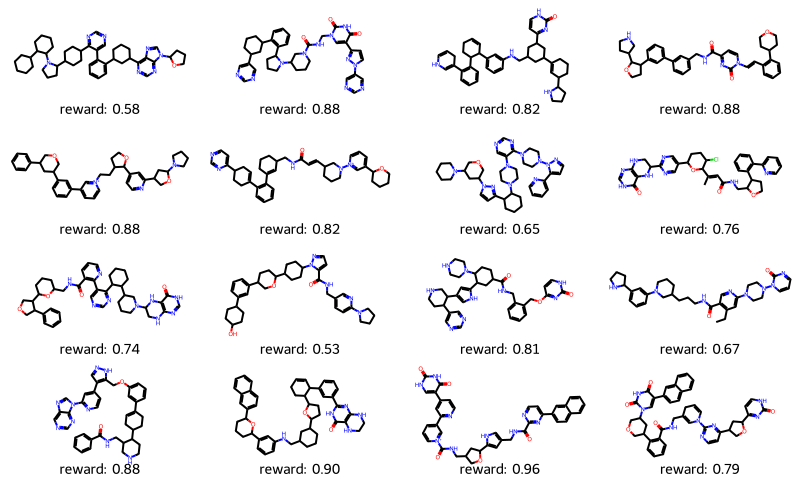

In [7]:
objs = [ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, _ = task.compute_obj_properties(objs)
log_rewards = task.cond_info_to_logreward({'beta': torch.ones(len(trajs))}, obj_props)
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage(objs[:16], molsPerRow=4, subImgSize=(200, 120), legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:16]])

In [8]:
#print(trajs)
#for i in trajs[0]["traj"]:
#    print(i[0])

#for i in backup["states"]:
#    print(i)
"""
from IPython.display import SVG, display
import base64
img = "PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIHhtbG5zOnJka2l0PSJodHRwOi8vd3d3LnJka2l0Lm9yZy94bWwiIHhtbG5zOnhsaW5rPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hsaW5rIiB2ZXJzaW9uPSIxLjEiIGJhc2VQcm9maWxlPSJmdWxsIiB4bWw6c3BhY2U9InByZXNlcnZlIiB3aWR0aD0iMjAwcHgiIGhlaWdodD0iMjAwcHgiIHZpZXdCb3g9IjAgMCAyMDAgMjAwIj4KPCEtLSBFTkQgT0YgSEVBREVSIC0tPgo8cmVjdCBzdHlsZT0ib3BhY2l0eToxLjA7ZmlsbDojRkZGRkZGO3N0cm9rZTpub25lIiB3aWR0aD0iMjAwLjAiIGhlaWdodD0iMjAwLjAiIHg9IjAuMCIgeT0iMC4wIj4gPC9yZWN0Pgo8cGF0aCBjbGFzcz0iYm9uZC0wIGF0b20tMCBhdG9tLTEiIGQ9Ik0gMTUyLjYsMTI4LjcgTCAxNDYuMiwxMzkuOCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0xIGF0b20tMSBhdG9tLTIiIGQ9Ik0gMTQ2LjIsMTM5LjggTCAxMzMuNCwxMzkuNyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0yIGF0b20tMiBhdG9tLTMiIGQ9Ik0gMTMzLjQsMTM5LjcgTCAxMzEuMCwxMzUuNSIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0yIGF0b20tMiBhdG9tLTMiIGQ9Ik0gMTMxLjAsMTM1LjUgTCAxMjguNSwxMzEuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6I0ZGMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zIGF0b20tMyBhdG9tLTQiIGQ9Ik0gMTI4LjUsMTI2LjEgTCAxMzEuMCwxMjEuOCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6I0ZGMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zIGF0b20tMyBhdG9tLTQiIGQ9Ik0gMTMxLjAsMTIxLjggTCAxMzMuNSwxMTcuNiIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC00IGF0b20tNCBhdG9tLTUiIGQ9Ik0gMTMzLjUsMTE3LjYgTCAxNDYuMywxMTcuNiIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC01IGF0b20tNSBhdG9tLTAiIGQ9Ik0gMTQ2LjMsMTE3LjYgTCAxNTIuNiwxMjguNyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC02IGF0b20tNiBhdG9tLTciIGQ9Ik0gMTI3LjEsMTA2LjUgTCAxMTQuNCwxMDUuMSIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC03IGF0b20tNyBhdG9tLTgiIGQ9Ik0gMTE0LjQsMTA1LjEgTCAxMTEuOCw5Mi41IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTcgYXRvbS03IGF0b20tOCIgZD0iTSAxMTYuMCwxMDMuMyBMIDExMy45LDkzLjUiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtOCBhdG9tLTggYXRvbS05IiBkPSJNIDExMS44LDkyLjUgTCAxMTYuMyw5MC4wIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTggYXRvbS04IGF0b20tOSIgZD0iTSAxMTYuMyw5MC4wIEwgMTIwLjgsODcuNCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDBGRjtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC05IGF0b20tOSBhdG9tLTEwIiBkPSJNIDEyNC45LDg4LjAgTCAxMjguNiw5MS40IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMEZGO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTkgYXRvbS05IGF0b20tMTAiIGQ9Ik0gMTI4LjYsOTEuNCBMIDEzMi40LDk0LjgiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMTAgYXRvbS0xMCBhdG9tLTYiIGQ9Ik0gMTMyLjQsOTQuOCBMIDEyNy4xLDEwNi41IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTEwIGF0b20tMTAgYXRvbS02IiBkPSJNIDEzMC4wLDk1LjMgTCAxMjUuOSwxMDQuNCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0xMSBhdG9tLTExIGF0b20tMTIiIGQ9Ik0gODkuNyw5NC44IEwgNzguMSw4OS41IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTEyIGF0b20tMTIgYXRvbS0xMyIgZD0iTSA3OC4xLDg5LjUgTCA3Ni44LDc2LjgiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMTMgYXRvbS0xMyBhdG9tLTE0IiBkPSJNIDc2LjgsNzYuOCBMIDg3LjEsNjkuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0xNCBhdG9tLTE0IGF0b20tMTUiIGQ9Ik0gODcuMSw2OS4zIEwgOTguOCw3NC42IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTE1IGF0b20tMTUgYXRvbS0xNiIgZD0iTSA5OC44LDc0LjYgTCAxMDAuMSw4Ny4zIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTE2IGF0b20tMTYgYXRvbS0xMSIgZD0iTSAxMDAuMSw4Ny4zIEwgODkuNyw5NC44IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTE3IGF0b20tMTggYXRvbS0xOSIgZD0iTSA0OC4wLDEwMy4zIEwgNTUuNSw5My4wIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTE4IGF0b20tMTkgYXRvbS0yMCIgZD0iTSA1NS41LDkzLjAgTCA2Ny43LDk3LjAiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMTggYXRvbS0xOSBhdG9tLTIwIiBkPSJNIDU2LjIsOTUuMyBMIDY1LjgsOTguNCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0xOSBhdG9tLTIwIGF0b20tMjEiIGQ9Ik0gNjcuNyw5Ny4wIEwgNjcuNywxMDIuMSIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0xOSBhdG9tLTIwIGF0b20tMjEiIGQ9Ik0gNjcuNywxMDIuMSBMIDY3LjYsMTA3LjMiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwRkY7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMjAgYXRvbS0yMSBhdG9tLTIyIiBkPSJNIDY1LjYsMTEwLjUgTCA2MC41LDExMi4xIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMEZGO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTIwIGF0b20tMjEgYXRvbS0yMiIgZD0iTSA2MC41LDExMi4xIEwgNTUuNCwxMTMuNyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0yMSBhdG9tLTIyIGF0b20tMTgiIGQ9Ik0gNTUuNCwxMTMuNyBMIDQ4LjAsMTAzLjMiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMjEgYXRvbS0yMiBhdG9tLTE4IiBkPSJNIDU2LjIsMTExLjUgTCA1MC4zLDEwMy4zIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTIyIGF0b20tMjMgYXRvbS0yNCIgZD0iTSAxNi4wLDkyLjEgTCAyOC44LDkyLjIiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMjMgYXRvbS0yNCBhdG9tLTI1IiBkPSJNIDI4LjgsOTIuMiBMIDM1LjIsMTAzLjMiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMjQgYXRvbS0yNSBhdG9tLTI2IiBkPSJNIDM1LjIsMTAzLjMgTCAyOC43LDExNC4zIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTI1IGF0b20tMjYgYXRvbS0yNyIgZD0iTSAyOC43LDExNC4zIEwgMTUuOSwxMTQuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0yNiBhdG9tLTI3IGF0b20tMjgiIGQ9Ik0gMTUuOSwxMTQuMyBMIDkuNiwxMDMuMiIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0yNyBhdG9tLTI4IGF0b20tMjMiIGQ9Ik0gOS42LDEwMy4yIEwgMTYuMCw5Mi4xIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTI4IGF0b20tMjkgYXRvbS0zMCIgZD0iTSAxNTIuNywxMDYuNiBMIDE1Ny45LDEwNi42IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTI4IGF0b20tMjkgYXRvbS0zMCIgZD0iTSAxNTcuOSwxMDYuNiBMIDE2My4xLDEwNi42IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojRkYwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTI5IGF0b20tMzEgYXRvbS0zMiIgZD0iTSAxNzYuMyw3NS4zIEwgMTY2LjgsODMuOCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zMCBhdG9tLTMyIGF0b20tMzMiIGQ9Ik0gMTY2LjgsODMuOCBMIDE3MS45LDk1LjYiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMzAgYXRvbS0zMiBhdG9tLTMzIiBkPSJNIDE2OS4xLDg0LjMgTCAxNzMuMSw5My41IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTMxIGF0b20tMzMgYXRvbS0zNCIgZD0iTSAxNzEuOSw5NS42IEwgMTc3LjMsOTUuMCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zMSBhdG9tLTMzIGF0b20tMzQiIGQ9Ik0gMTc3LjMsOTUuMCBMIDE4Mi42LDk0LjUiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwRkY7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMzIgYXRvbS0zNCBhdG9tLTM1IiBkPSJNIDE4NS4yLDkxLjcgTCAxODYuMyw4Ni43IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMEZGO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTMyIGF0b20tMzQgYXRvbS0zNSIgZD0iTSAxODYuMyw4Ni43IEwgMTg3LjQsODEuOCIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zMyBhdG9tLTM1IGF0b20tMzEiIGQ9Ik0gMTg3LjQsODEuOCBMIDE3Ni4zLDc1LjMiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMzMgYXRvbS0zNSBhdG9tLTMxIiBkPSJNIDE4NS4yLDgyLjcgTCAxNzYuNiw3Ny43IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTM0IGF0b20tMzYgYXRvbS0zNyIgZD0iTSAxMzEuMiw2NC45IEwgMTIwLjksNzIuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zNSBhdG9tLTM3IGF0b20tMzgiIGQ9Ik0gMTIwLjksNzIuMyBMIDEwOS4yLDY3LjEiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMzYgYXRvbS0zOCBhdG9tLTM5IiBkPSJNIDEwOS4yLDY3LjEgTCAxMDcuOSw1NC40IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTM3IGF0b20tMzkgYXRvbS00MCIgZD0iTSAxMDcuOSw1NC40IEwgMTE4LjMsNDYuOSIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC0zOCBhdG9tLTQwIGF0b20tNDEiIGQ9Ik0gMTE4LjMsNDYuOSBMIDEzMC4wLDUyLjEiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtMzkgYXRvbS00MSBhdG9tLTM2IiBkPSJNIDEzMC4wLDUyLjEgTCAxMzEuMiw2NC45IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTQwIGF0b20tNCBhdG9tLTYiIGQ9Ik0gMTMzLjUsMTE3LjYgTCAxMjcuMSwxMDYuNSIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC00MSBhdG9tLTEgYXRvbS0xNyIgZD0iTSAxNDYuMiwxMzkuOCBMIDE0OC42LDE0NC4xIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTQxIGF0b20tMSBhdG9tLTE3IiBkPSJNIDE0OC42LDE0NC4xIEwgMTUxLjEsMTQ4LjMiIHN0eWxlPSJmaWxsOm5vbmU7ZmlsbC1ydWxlOmV2ZW5vZGQ7c3Ryb2tlOiNDQ0NDMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjEiLz4KPHBhdGggY2xhc3M9ImJvbmQtNDIgYXRvbS01IGF0b20tMjkiIGQ9Ik0gMTQ2LjMsMTE3LjYgTCAxNTIuNywxMDYuNiIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC00MyBhdG9tLTggYXRvbS0xNiIgZD0iTSAxMTEuOCw5Mi41IEwgMTAwLjEsODcuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC00NCBhdG9tLTEyIGF0b20tMjAiIGQ9Ik0gNzguMSw4OS41IEwgNjcuNyw5Ny4wIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTQ1IGF0b20tMTUgYXRvbS0zOCIgZD0iTSA5OC44LDc0LjYgTCAxMDkuMiw2Ny4xIiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTQ2IGF0b20tMTggYXRvbS0yNSIgZD0iTSA0OC4wLDEwMy4zIEwgMzUuMiwxMDMuMyIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBjbGFzcz0iYm9uZC00NyBhdG9tLTMwIGF0b20tMzMiIGQ9Ik0gMTY3LjAsMTA0LjAgTCAxNjkuNSw5OS44IiBzdHlsZT0iZmlsbDpub25lO2ZpbGwtcnVsZTpldmVub2RkO3N0cm9rZTojRkYwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxIi8+CjxwYXRoIGNsYXNzPSJib25kLTQ3IGF0b20tMzAgYXRvbS0zMyIgZD0iTSAxNjkuNSw5OS44IEwgMTcxLjksOTUuNiIgc3R5bGU9ImZpbGw6bm9uZTtmaWxsLXJ1bGU6ZXZlbm9kZDtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MSIvPgo8cGF0aCBkPSJNIDE1Mi4zLDEyOS4zIEwgMTUyLjYsMTI4LjcgTCAxNTIuMywxMjguMiIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSAxMzQuMCwxMzkuNyBMIDEzMy40LDEzOS43IEwgMTMzLjMsMTM5LjUiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gMTE1LjAsMTA1LjEgTCAxMTQuNCwxMDUuMSBMIDExNC4zLDEwNC40IiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDEzMi4yLDk0LjYgTCAxMzIuNCw5NC44IEwgMTMyLjEsOTUuNCIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSA4OS4xLDk0LjUgTCA4OS43LDk0LjggTCA5MC4yLDk0LjQiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gNzYuOCw3Ny40IEwgNzYuOCw3Ni44IEwgNzcuMyw3Ni40IiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDg2LjYsNjkuNyBMIDg3LjEsNjkuMyBMIDg3LjcsNjkuNiIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSA1NS4xLDkzLjUgTCA1NS41LDkzLjAgTCA1Ni4xLDkzLjIiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gNTUuNywxMTMuNiBMIDU1LjQsMTEzLjcgTCA1NS4xLDExMy4yIiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDE2LjcsOTIuMSBMIDE2LjAsOTIuMSBMIDE1LjcsOTIuNyIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSAyOC4yLDkyLjIgTCAyOC44LDkyLjIgTCAyOS4xLDkyLjciIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gMjkuMCwxMTMuOCBMIDI4LjcsMTE0LjMgTCAyOC4xLDExNC4zIiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDE2LjYsMTE0LjMgTCAxNS45LDExNC4zIEwgMTUuNiwxMTMuNyIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSA5LjksMTAzLjcgTCA5LjYsMTAzLjIgTCA5LjksMTAyLjYiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gMTUzLjAsMTA2LjYgTCAxNTIuNywxMDYuNiBMIDE1Mi40LDEwNy4xIiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDE3NS44LDc1LjcgTCAxNzYuMyw3NS4zIEwgMTc2LjksNzUuNiIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSAxNjcuMyw4My40IEwgMTY2LjgsODMuOCBMIDE2Ny4wLDg0LjQiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gMTg3LjMsODIuMCBMIDE4Ny40LDgxLjggTCAxODYuOCw4MS40IiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDEzMC43LDY1LjIgTCAxMzEuMiw2NC45IEwgMTMxLjIsNjQuMiIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSAxMjEuNCw3Mi4wIEwgMTIwLjksNzIuMyBMIDEyMC4zLDcyLjEiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGQ9Ik0gMTA4LjAsNTUuMCBMIDEwNy45LDU0LjQgTCAxMDguNCw1NC4wIiBzdHlsZT0iZmlsbDpub25lO3N0cm9rZTojMDAwMDAwO3N0cm9rZS13aWR0aDoyLjBweDtzdHJva2UtbGluZWNhcDpidXR0O3N0cm9rZS1saW5lam9pbjptaXRlcjtzdHJva2Utb3BhY2l0eToxOyIvPgo8cGF0aCBkPSJNIDExNy44LDQ3LjMgTCAxMTguMyw0Ni45IEwgMTE4LjksNDcuMSIgc3R5bGU9ImZpbGw6bm9uZTtzdHJva2U6IzAwMDAwMDtzdHJva2Utd2lkdGg6Mi4wcHg7c3Ryb2tlLWxpbmVjYXA6YnV0dDtzdHJva2UtbGluZWpvaW46bWl0ZXI7c3Ryb2tlLW9wYWNpdHk6MTsiLz4KPHBhdGggZD0iTSAxMjkuNCw1MS45IEwgMTMwLjAsNTIuMSBMIDEzMC4wLDUyLjgiIHN0eWxlPSJmaWxsOm5vbmU7c3Ryb2tlOiMwMDAwMDA7c3Ryb2tlLXdpZHRoOjIuMHB4O3N0cm9rZS1saW5lY2FwOmJ1dHQ7c3Ryb2tlLWxpbmVqb2luOm1pdGVyO3N0cm9rZS1vcGFjaXR5OjE7Ii8+CjxwYXRoIGNsYXNzPSJhdG9tLTMiIGQ9Ik0gMTI1LjEgMTI4LjYgUSAxMjUuMSAxMjcuNiwgMTI1LjYgMTI3LjAgUSAxMjYuMSAxMjYuNSwgMTI3LjAgMTI2LjUgUSAxMjguMCAxMjYuNSwgMTI4LjUgMTI3LjAgUSAxMjkuMCAxMjcuNiwgMTI5LjAgMTI4LjYgUSAxMjkuMCAxMjkuNywgMTI4LjUgMTMwLjMgUSAxMjguMCAxMzAuOCwgMTI3LjAgMTMwLjggUSAxMjYuMSAxMzAuOCwgMTI1LjYgMTMwLjMgUSAxMjUuMSAxMjkuNywgMTI1LjEgMTI4LjYgTSAxMjcuMCAxMzAuNCBRIDEyNy43IDEzMC40LCAxMjguMCAxMjkuOSBRIDEyOC40IDEyOS41LCAxMjguNCAxMjguNiBRIDEyOC40IDEyNy44LCAxMjguMCAxMjcuNCBRIDEyNy43IDEyNy4wLCAxMjcuMCAxMjcuMCBRIDEyNi40IDEyNy4wLCAxMjYuMCAxMjcuNCBRIDEyNS43IDEyNy44LCAxMjUuNyAxMjguNiBRIDEyNS43IDEyOS41LCAxMjYuMCAxMjkuOSBRIDEyNi40IDEzMC40LCAxMjcuMCAxMzAuNCAiIGZpbGw9IiNGRjAwMDAiLz4KPHBhdGggY2xhc3M9ImF0b20tOSIgZD0iTSAxMjEuOSA4NC4xIEwgMTIzLjMgODYuMyBRIDEyMy41IDg2LjUsIDEyMy43IDg2LjkgUSAxMjMuOSA4Ny4zLCAxMjMuOSA4Ny40IEwgMTIzLjkgODQuMSBMIDEyNC41IDg0LjEgTCAxMjQuNSA4OC4zIEwgMTIzLjkgODguMyBMIDEyMi40IDg1LjkgUSAxMjIuMiA4NS42LCAxMjIuMSA4NS4yIFEgMTIxLjkgODQuOSwgMTIxLjggODQuOCBMIDEyMS44IDg4LjMgTCAxMjEuMyA4OC4zIEwgMTIxLjMgODQuMSBMIDEyMS45IDg0LjEgIiBmaWxsPSIjMDAwMEZGIi8+CjxwYXRoIGNsYXNzPSJhdG9tLTkiIGQ9Ik0gMTIxLjIgNzkuNCBMIDEyMS44IDc5LjQgTCAxMjEuOCA4MS4yIEwgMTI0LjAgODEuMiBMIDEyNC4wIDc5LjQgTCAxMjQuNSA3OS40IEwgMTI0LjUgODMuNiBMIDEyNC4wIDgzLjYgTCAxMjQuMCA4MS43IEwgMTIxLjggODEuNyBMIDEyMS44IDgzLjYgTCAxMjEuMiA4My42IEwgMTIxLjIgNzkuNCAiIGZpbGw9IiMwMDAwRkYiLz4KPHBhdGggY2xhc3M9ImF0b20tMTciIGQ9Ik0gMTUxLjMgMTUyLjMgUSAxNTEuNCAxNTIuNCwgMTUxLjYgMTUyLjUgUSAxNTEuOCAxNTIuNSwgMTUyLjAgMTUyLjYgUSAxNTIuMiAxNTIuNiwgMTUyLjQgMTUyLjYgUSAxNTIuOCAxNTIuNiwgMTUzLjEgMTUyLjQgUSAxNTMuMyAxNTIuMiwgMTUzLjMgMTUxLjkgUSAxNTMuMyAxNTEuNywgMTUzLjIgMTUxLjUgUSAxNTMuMSAxNTEuNCwgMTUyLjkgMTUxLjMgUSAxNTIuNyAxNTEuMiwgMTUyLjQgMTUxLjEgUSAxNTIuMCAxNTEuMCwgMTUxLjggMTUwLjkgUSAxNTEuNiAxNTAuOCwgMTUxLjQgMTUwLjYgUSAxNTEuMyAxNTAuNCwgMTUxLjMgMTUwLjAgUSAxNTEuMyAxNDkuNCwgMTUxLjYgMTQ5LjEgUSAxNTIuMCAxNDguOCwgMTUyLjcgMTQ4LjggUSAxNTMuMiAxNDguOCwgMTUzLjggMTQ5LjAgTCAxNTMuNiAxNDkuNSBRIDE1My4xIDE0OS4zLCAxNTIuNyAxNDkuMyBRIDE1Mi4zIDE0OS4zLCAxNTIuMSAxNDkuNCBRIDE1MS44IDE0OS42LCAxNTEuOSAxNDkuOSBRIDE1MS45IDE1MC4xLCAxNTIuMCAxNTAuMyBRIDE1Mi4xIDE1MC40LCAxNTIuMyAxNTAuNSBRIDE1Mi40IDE1MC42LCAxNTIuNyAxNTAuNiBRIDE1My4xIDE1MC44LCAxNTMuMyAxNTAuOSBRIDE1My42IDE1MS4wLCAxNTMuNyAxNTEuMyBRIDE1My45IDE1MS41LCAxNTMuOSAxNTEuOSBRIDE1My45IDE1Mi41LCAxNTMuNSAxNTIuOCBRIDE1My4xIDE1My4xLCAxNTIuNCAxNTMuMSBRIDE1Mi4xIDE1My4xLCAxNTEuOCAxNTMuMCBRIDE1MS41IDE1My4wLCAxNTEuMiAxNTIuOCBMIDE1MS4zIDE1Mi4zICIgZmlsbD0iI0NDQ0MwMCIvPgo8cGF0aCBjbGFzcz0iYXRvbS0xNyIgZD0iTSAxNTQuNSAxNDguOCBMIDE1NS4wIDE0OC44IEwgMTU1LjAgMTUwLjYgTCAxNTcuMiAxNTAuNiBMIDE1Ny4yIDE0OC44IEwgMTU3LjggMTQ4LjggTCAxNTcuOCAxNTMuMCBMIDE1Ny4yIDE1My4wIEwgMTU3LjIgMTUxLjAgTCAxNTUuMCAxNTEuMCBMIDE1NS4wIDE1My4wIEwgMTU0LjUgMTUzLjAgTCAxNTQuNSAxNDguOCAiIGZpbGw9IiNDQ0NDMDAiLz4KPHBhdGggY2xhc3M9ImF0b20tMjEiIGQ9Ik0gNjYuNyAxMDcuNyBMIDY4LjEgMTA5LjkgUSA2OC4yIDExMC4yLCA2OC40IDExMC42IFEgNjguNyAxMTEuMCwgNjguNyAxMTEuMCBMIDY4LjcgMTA3LjcgTCA2OS4yIDEwNy43IEwgNjkuMiAxMTEuOSBMIDY4LjcgMTExLjkgTCA2Ny4yIDEwOS41IFEgNjcuMCAxMDkuMiwgNjYuOCAxMDguOSBRIDY2LjYgMTA4LjUsIDY2LjYgMTA4LjQgTCA2Ni42IDExMS45IEwgNjYuMCAxMTEuOSBMIDY2LjAgMTA3LjcgTCA2Ni43IDEwNy43ICIgZmlsbD0iIzAwMDBGRiIvPgo8cGF0aCBjbGFzcz0iYXRvbS0yMSIgZD0iTSA3MC4xIDEwNy43IEwgNzAuNiAxMDcuNyBMIDcwLjYgMTA5LjUgTCA3Mi44IDEwOS41IEwgNzIuOCAxMDcuNyBMIDczLjQgMTA3LjcgTCA3My40IDExMS45IEwgNzIuOCAxMTEuOSBMIDcyLjggMTEwLjAgTCA3MC42IDExMC4wIEwgNzAuNiAxMTEuOSBMIDcwLjEgMTExLjkgTCA3MC4xIDEwNy43ICIgZmlsbD0iIzAwMDBGRiIvPgo8cGF0aCBjbGFzcz0iYXRvbS0zMCIgZD0iTSAxNjMuNSAxMDYuNiBRIDE2My41IDEwNS42LCAxNjQuMCAxMDUuMCBRIDE2NC42IDEwNC41LCAxNjUuNSAxMDQuNSBRIDE2Ni40IDEwNC41LCAxNjYuOSAxMDUuMCBRIDE2Ny40IDEwNS42LCAxNjcuNCAxMDYuNiBRIDE2Ny40IDEwNy43LCAxNjYuOSAxMDguMiBRIDE2Ni40IDEwOC44LCAxNjUuNSAxMDguOCBRIDE2NC42IDEwOC44LCAxNjQuMCAxMDguMiBRIDE2My41IDEwNy43LCAxNjMuNSAxMDYuNiBNIDE2NS41IDEwOC4zIFEgMTY2LjEgMTA4LjMsIDE2Ni41IDEwNy45IFEgMTY2LjggMTA3LjUsIDE2Ni44IDEwNi42IFEgMTY2LjggMTA1LjgsIDE2Ni41IDEwNS40IFEgMTY2LjEgMTA0LjksIDE2NS41IDEwNC45IFEgMTY0LjggMTA0LjksIDE2NC41IDEwNS40IFEgMTY0LjEgMTA1LjgsIDE2NC4xIDEwNi42IFEgMTY0LjEgMTA3LjUsIDE2NC41IDEwNy45IFEgMTY0LjggMTA4LjMsIDE2NS41IDEwOC4zICIgZmlsbD0iI0ZGMDAwMCIvPgo8cGF0aCBjbGFzcz0iYXRvbS0zNCIgZD0iTSAxODMuNyA5Mi4xIEwgMTg1LjEgOTQuNCBRIDE4NS4zIDk0LjYsIDE4NS41IDk1LjAgUSAxODUuNyA5NS40LCAxODUuNyA5NS40IEwgMTg1LjcgOTIuMSBMIDE4Ni4zIDkyLjEgTCAxODYuMyA5Ni40IEwgMTg1LjcgOTYuNCBMIDE4NC4yIDkzLjkgUSAxODQuMCA5My42LCAxODMuOCA5My4zIFEgMTgzLjcgOTMuMCwgMTgzLjYgOTIuOSBMIDE4My42IDk2LjQgTCAxODMuMSA5Ni40IEwgMTgzLjEgOTIuMSBMIDE4My43IDkyLjEgIiBmaWxsPSIjMDAwMEZGIi8+CjxwYXRoIGNsYXNzPSJhdG9tLTM0IiBkPSJNIDE4Ny4xIDkyLjEgTCAxODcuNyA5Mi4xIEwgMTg3LjcgOTMuOSBMIDE4OS44IDkzLjkgTCAxODkuOCA5Mi4xIEwgMTkwLjQgOTIuMSBMIDE5MC40IDk2LjQgTCAxODkuOCA5Ni40IEwgMTg5LjggOTQuNCBMIDE4Ny43IDk0LjQgTCAxODcuNyA5Ni40IEwgMTg3LjEgOTYuNCBMIDE4Ny4xIDkyLjEgIiBmaWxsPSIjMDAwMEZGIi8+Cjwvc3ZnPg=="
svg_str = base64.b64decode(img).decode("utf-8")

# Display
display(SVG(svg_str))"""
from rdkit.Chem import AllChem, DataStructs
radius=2
n_bits=1024
for i, mol in enumerate(mols[:50]):
    if mol is None:
        print(f"{i}: mol is None")
        continue
    try:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=np.int32)
        Chem.DataStructs.ConvertToNumpyArray(fp, arr)
        print(fp)
    except Exception as e:
        print(f"{i}: fingerprint failed -> {e}")



"""batch_idx = []
states = []
logprobs_bw=[]
logprobs_fw=[]
for i, t in enumerate(trajs):
    tl = len(t["traj"])
    batch_idx += [i]*tl
    for s in t["traj"]:
        states.append(s[0])
    logprobs_bw.append(t["bck_logprobs"])
    logprobs_fw.append(t["fwd_logprobs"])
logprobs_bw = torch.cat(logprobs_bw)
logprobs_fw = torch.cat(logprobs_fw)
print(len(batch_idx), len(states), len(logprobs_bw), len(logprobs_fw))"""

print(logger.top)

3: fingerprint failed -> Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.5
	BOOST: 1_78

4: fingerprint failed -> Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.5
	BOOST: 1_78

5: fingerprint failed -> Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.5
	BOOST: 1_78

6: fingerprint failed -> Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.5
	BOOST: 1_78

7: fingerprint failed -> Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 52 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2023.09.5
	BOOST: 1

In [9]:
print(log_rewards)

tensor([-0.5533, -0.1261, -0.1985, -0.1278, -0.1319, -0.2009, -0.4314, -0.2719,
        -0.3048, -0.6359, -0.2131, -0.3983, -0.1317, -0.1050, -0.0403, -0.2385,
        -0.0729, -0.0645, -0.1406, -0.1878, -0.2852, -0.1753, -0.1380, -0.2010,
        -0.4392, -0.1706, -0.1640, -0.1065, -0.1208, -0.1374, -0.1958, -0.1706,
        -0.2446, -0.1258, -0.1761, -0.1295, -0.1301, -0.1100, -0.2038, -0.3079,
        -0.2683, -0.0919, -0.3932, -0.3026, -0.1534, -0.0845, -0.1303, -0.2429,
        -0.4238, -0.1161, -0.2456, -0.1108, -0.2165, -0.2173, -0.3854, -0.1681,
        -0.1302, -0.3420, -0.2190, -0.1891, -0.2795, -0.5371, -0.5243, -0.1122])
